# Variables Demográficas

El tener múltiples características demográficas y geográficas de los autores de los tweets recolectados nos permite poder comprender como  des que cada país aborda el tema de la migración. Así como cada género, estatus socioeconómico, etc. nos ayuda a entender el fenómeno hacia dentro de cada país.

In [1]:
import os
import re
import ast
import pandas as pd
import seaborn

import helpers.preprocess_text as pre_text
import helpers.preprocess_location as pre_loc
from helpers.here_api import normalize_user_location_here_api

## Geolocalización

Para el Laboratorio de Percepción y Migración se le dio prioridad el asignar un país de procedencia a la mayor cantidad de usuarios captados, esto para poder graficar el volumen aproximado de cada país, el tono y de que temas hablan sobre la migración.

Para lograr esto, seguimos dos metodos:

### Extraelo del objeto geo del tweet

Por defecto, Twitter intenta recolectar la información de geolocalización de sus usuarios y es por eso que hay tweets que un campo referente al país, ciudad y aproximación de coordenadas. Hay que tener en cuenta que la mayoría de los usuarios tienen esto desactivado, por lo que el volumen con esta información va a ser muy reducido. Aunque esto no lo hace menos útil. 

In [2]:
# Cargar tweets del dataset ejemplo
df_tweets = pd.read_json("./files/1_dataset.jsonl", lines=True)
df_tweets = df_tweets[['id', 'author_id', 'geo']]

# Cargar los objetos anidados geo
df_geo = pd.DataFrame(list(df_tweets['geo']))
df_geo = df_geo.drop(columns=['id'])

df_tweets = df_tweets.drop(columns=['geo'])
df_tweets = df_tweets.join(df_geo)

del df_geo

df_tweets

,id,author_id,place_id,country_code,name,country,place_type,geo,full_name,coordinates
0,1568384770672934912,2671423238,00a8d523465806f4,AR,Colón,Argentina,city,"{'type': 'Feature', 'bbox': [-64.122293, -31.0...","Colón, Argentina",NaN
1,1568384665731440640,1361302057945333760,666f0989b9fd5616,CO,Antioquia,Colombia,admin,"{'type': 'Feature', 'bbox': [-77.1214380001307...","Antioquia, Colombia",NaN
2,1568357940461191168,1391458758459600896,de24fd487f41bad3,MX,Iztacalco,México,city,"{'type': 'Feature', 'bbox': [-99.137171, 19.37...","Iztacalco, Distrito Federal",NaN
3,1568337671931691008,1149464602452877312,018f1cde6bad9747,AR,Ciudad Autónoma de Buenos Aires,Argentina,city,"{'type': 'Feature', 'bbox': [-58.5317922, -34....","Ciudad Autónoma de Buenos Aires, Argentina",NaN
4,1568333644934135808,119160105,00f84d414936f28e,AR,Córdoba,Argentina,city,"{'type': 'Feature', 'bbox': [-64.3195, -31.523...","Córdoba, Argentina","{'type': 'Point', 'coordinates': [-64.1847387,..."
...,...,...,...,...,...,...,...,...,...,...
8764,1477088691877261312,397706715,0105a80417c159b4,CO,Barranquilla,Colombia,city,"{'type': 'Feature', 'bbox': [-74.9257650027657...","Barranquilla, Colombia",NaN
8765,1477088689901682688,397706715,0105a80417c159b4,CO,Barranquilla,Colombia,city,"{'type': 'Feature', 'bbox': [-74.9257650027657...","Barranquilla, Colombia",NaN
8766,1477086472469684224,1176580744036196352,7262f97768b53492,MX,Huixtla,México,city,"{'type': 'Feature', 'bbox': [-92.7213064, 14.9...","Huixtla, Chiapas",NaN
8767,1477067319830478848,579360940,018f1cde6bad9747,AR,Ciudad Autónoma de Buenos Aires,Argentina,city,"{'type': 'Feature', 'bbox': [-58.5317922, -34....","Ciudad Autónoma de Buenos Aires, Argentina",NaN


Esta función se encarga de extraer los datos como el nombre del país, ciudad y coordenadas en las que Twitter logró aproximar la posición del usuario y lo estructura en las columnas finales.

In [3]:
def normalize_twitter_geolocation(df_data):

    # TODO: Make this a wrapper(?)
    df_countries = pd.read_csv(f"./resources/countries_data.csv",
                               usecols=['ISO_2', 'ISO_3', 'name_short_es'],
                               sep='\t')

    ISO_codes = dict(df_countries.iloc[:, :2].values)
    countries_names = dict(df_countries.iloc[:, [0, 2]].values)

    # Normalize author country data
    srs_country_codes = df_data['country_code']
    df_data['country_code'] = srs_country_codes.map(ISO_codes)
    df_data['country_name'] = srs_country_codes.map(
        countries_names)

    # Normalize federal divisions
    admin_index = (df_data['place_type'] == 'admin')
    df_data['federal_division'] = df_data[admin_index]['name']

    # Normalize cities
    city_index = (df_data['place_type'] == 'city')
    df_data['city'] = df_data[city_index]['name']
    
    # Get bbox centroid
    df_data['geo_type'] = df_data['geo'].apply(lambda x: x['type'])
    df_data['geo_bbox'] = df_data['geo'].apply(lambda x: x['bbox'])
    df_data['latitude'] = df_data['geo_bbox'].apply(lambda x: (x[1]+x[3])/2)
    df_data['longitude'] = df_data['geo_bbox'].apply(lambda x: (x[0]+x[2])/2)

    return df_data

Esta función se aplica para cada tweet que tenga información sobre su geolocalización.

In [4]:
df_ids = df_tweets[['id', 'place_id']]
df_ids

,id,place_id
0,1568384770672934912,00a8d523465806f4
1,1568384665731440640,666f0989b9fd5616
2,1568357940461191168,de24fd487f41bad3
3,1568337671931691008,018f1cde6bad9747
4,1568333644934135808,00f84d414936f28e
...,...,...
8764,1477088691877261312,0105a80417c159b4
8765,1477088689901682688,0105a80417c159b4
8766,1477086472469684224,7262f97768b53492
8767,1477067319830478848,018f1cde6bad9747


In [5]:
df_geolocs = df_tweets.iloc[:, 1:].dropna(subset=['place_id']) \
                      .drop_duplicates(subset=['place_id'])
df_geolocs = normalize_twitter_geolocation(df_geolocs)
df_geolocs = df_geolocs[['place_id', 'country_code', 
                         'country_name', 'federal_division', 'city', 
                         'latitude', 'longitude']]
df_geolocs

,place_id,country_code,country_name,federal_division,city,latitude,longitude
0,00a8d523465806f4,ARG,Argentina,NaN,Colón,-31.000023,-64.086213
1,666f0989b9fd5616,COL,Colombia,Antioquia,NaN,7.139205,-75.508819
2,de24fd487f41bad3,MEX,México,NaN,Iztacalco,19.399101,-99.096496
3,018f1cde6bad9747,ARG,Argentina,NaN,Ciudad Autónoma de Buenos Aires,-34.604315,-58.442643
4,00f84d414936f28e,ARG,Argentina,NaN,Córdoba,-31.415457,-64.198026
...,...,...,...,...,...,...,...
8742,01e2d9bb7bfd4799,COL,Colombia,NaN,Belalcázar,4.977568,-75.863214
8747,00b62c7d4e24b866,ARG,Argentina,NaN,San Lorenzo,-32.749032,-60.746994
8753,7fb5c5b050f42ca5,COL,Colombia,Cundinamarca,NaN,4.766092,-73.995244
8756,25904a4dfba77093,MEX,México,NaN,Ezequiel Montes,20.653227,-99.860001


In [6]:
df_geo = df_ids.merge(df_geolocs, on='place_id', how='left')
df_geo = df_geo[~df_geo['country_code'].isna()]
df_geo

,id,place_id,country_code,country_name,federal_division,city,latitude,longitude
0,1568384770672934912,00a8d523465806f4,ARG,Argentina,NaN,Colón,-31.000023,-64.086213
1,1568384665731440640,666f0989b9fd5616,COL,Colombia,Antioquia,NaN,7.139205,-75.508819
2,1568357940461191168,de24fd487f41bad3,MEX,México,NaN,Iztacalco,19.399101,-99.096496
3,1568337671931691008,018f1cde6bad9747,ARG,Argentina,NaN,Ciudad Autónoma de Buenos Aires,-34.604315,-58.442643
4,1568333644934135808,00f84d414936f28e,ARG,Argentina,NaN,Córdoba,-31.415457,-64.198026
...,...,...,...,...,...,...,...,...
8764,1477088691877261312,0105a80417c159b4,COL,Colombia,NaN,Barranquilla,10.958073,-74.849933
8765,1477088689901682688,0105a80417c159b4,COL,Colombia,NaN,Barranquilla,10.958073,-74.849933
8766,1477086472469684224,7262f97768b53492,MEX,México,NaN,Huixtla,15.125592,-92.563117
8767,1477067319830478848,018f1cde6bad9747,ARG,Argentina,NaN,Ciudad Autónoma de Buenos Aires,-34.604315,-58.442643


### Inferirla basado en atributo *location* del usuario

Como mencionamos antes, la gran mayoría de los usuarios no le permiten a twitter recolectar información de su localización, para esto tenemos que inferir su localización por medio de otros atributos. 

El atributo más útil es *location* que está dentro del objeto usuario de cada tweet. Este es un campo abierto donde cada usuario puede poner lo que desee y como lo desee, por lo que siempre va a haber incertidumbre. Pero está centrado en la locación del usuario y una gran parte de ellos si podrá información útil para inferir, por lo menos su país de procedencia, pero puede llegar hasta a nivel ciudad.

In [7]:
# Cargar tweets del dataset ejemplo
df_tweets = pd.read_json("./files/2_dataset.jsonl", lines=True)
df_tweets = df_tweets[['id', 'author_id', 'author']]

# Cargar los objetos anidados geo
df_authors = pd.DataFrame(list(df_tweets['author']))
df_authors = df_authors[['location', 'description']]
df_authors.columns = list(map(lambda x: f"author_{x}", df_authors.columns))

df_tweets = df_tweets.drop(columns=['author'])
df_tweets = df_tweets.join(df_authors)

del df_authors

df_tweets

,id,author_id,author_location,author_description
0,1568750927091204096,3240913424,NaN,🇪🇸#SiguemeYTeSigo💚\nNo contesto MD. Abstenerse...
1,1568750887811842048,1534599690976641024,NaN,"Me gusta mucho oir música, bailar y disfrutar ..."
2,1568750811181907968,1438312447006416896,NaN,
3,1568750753459699712,2939077769,San Cristóbal de las Casas,"Historiador, crítico del sistema, profesor uni..."
4,1568750738242785280,1455947779004682240,NaN,Judío come camarones!
...,...,...,...,...
13675,1568026433125240832,2445464580,🇪🇨 Ecuador 🇷🇺 Rusia 🇵🇸,"Tienen la fuerza, podrán avasallarnos, pero no..."
13676,1568026421724909568,1525993050815840256,NaN,
13677,1568026416859447296,1399172510550220800,"Sevilla, España",saranghae 💃 🇪🇦
13678,1568026401558740992,1316432632373219328,Cúcuta. Colombia,🚩Cuenta oficial de @Siemprevenezuela \nRevista...


Hay que obtener los valores del atributo locación y pre-procesarlos. Es significa, pasar todo a minúsculas, quitar acentos y caracteres especiales, quitar emojis, completar abstracciones, etc. El objetivo es dejar esos valores lo más limpio y normalizados posible.

Nota: La función de preprocesamiento se puede ver en el archivo ./helpers/preprocess_location.py.

In [8]:
# Dejar solo los textos de locations sin duplicados ni nulos
df_unique_locs = df_tweets[['author_location']].drop_duplicates() \
                                        .dropna() \
                                        .reset_index(drop=True) \
                                        .copy()
df_unique_locs['author_location_processed'] = df_unique_locs['author_location']

# Preprocesar los strings de locations
df_unique_locs = pre_loc.preprocessing_location_string(df_unique_locs)
df_unique_locs

,author_location,author_location_processed
0,San Cristóbal de las Casas,san cristobal de las casas
1,"Lisboa, Portugal",lisboa portugal
2,MÉXICO,mexico
3,"Miguel Hidalgo, Tenochtitlan",miguel hidalgo tenochtitlan
4,Cuenca - Ecuador,cuenca ecuador
...,...,...
3015,"Angola, Luanda📍🇦🇴",angola luanda
3017,"Villa el Salvador, Peru",vila el salvador peru
3018,Manzanares,manzanares
3019,Jalisco 🇲🇽✝️☸️☯️🇲🇽,jalisco


Se descartan valores que contenga nombres de países que no sean de nuestro interés, que contenga dos o más países, etc.

In [10]:
df_unique_locs = df_unique_locs[['author_location_processed']].drop_duplicates() \
                                                              .reset_index(drop=True).copy()

# Validar locations ya preprocesadas
df_unique_locs = pre_loc.validate_author_locations(df_unique_locs.copy())
df_unique_locs = df_unique_locs[df_unique_locs['author_location_is_valid']].reset_index(drop=True)
df_unique_locs

,author_location_processed,author_location_is_valid
0,san cristobal de las casas,True
1,mexico,True
2,miguel hidalgo tenochtitlan,True
3,cuenca ecuador,True
4,pachuca de soto hidalgo,True
...,...,...
1813,alcala de henares,True
1814,ciudad autonoma de buenos aires,True
1815,siberia gasteiz,True
1816,manzanares,True


Se descartan las cadenas de texto que ya se han normalizado con anterioridad.

In [13]:
df_prev =  pd.read_csv('./resources/user_location_none.csv',
                       usecols=['a_proc_loc'])
df_prev = df_prev.append(pd.read_csv('./resources/user_location_invalids.csv',
                                     usecols=['a_proc_loc']))
df_prev = df_prev.append(pd.read_csv('./resources/user_location_valids.csv',
                                     usecols=['a_proc_loc']))

df_unique_locs = df_unique_locs[~df_unique_locs['author_location_processed'].isin(df_prev['a_proc_loc'])]
df_unique_locs = df_unique_locs.reset_index(drop=True)
df_unique_locs

<ipython-input-13-b4014dc5f0e8>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prev = df_prev.append(pd.read_csv('./resources/user_location_invalids.csv',
<ipython-input-13-b4014dc5f0e8>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prev = df_prev.append(pd.read_csv('./resources/user_location_valids.csv',


,author_location_processed,author_location_is_valid
0,proudly pagan,True
1,fuerteventura moro jable,True
2,gobiernan covidiotas,True
3,cale tristeza esquina agonia,True
4,santiago ixc nayarit,True
...,...,...
87,cokielandia,True
88,guayacan carupano,True
89,uruguay departamento de flores,True
90,antar,True


Para el proceso de inferencia, nos apoyamos de una API llamada HERE. Tiene múltiples servicios relacionados con mapas, geolocalización, etc. En específico nos interesa el de autocompletado, con esto podemos inferir (aprovechando la basta experiencia y cantidad de datos de HERE) la locación del usuario que realizo los tweets.

Para poder utilizarla, hay que crear un usuario, dar de alta un proyecto y obtener las credenciales. [Aquí un guía para iniciar.](https://developer.here.com/documentation/geocoding-search-api/dev_guide/index.html)

In [14]:
CREDENTIALS_HERE_API = "3ZIwY935vwQvn04EhXz7rZ55qDTv3iOFMDbTFzk6yw4"

In [15]:
df_data_locs, df_invalids_locs, df_none_locs = normalize_user_location_here_api(df_unique_locs, CREDENTIALS_HERE_API)

92 user locations to normalize


0it [00:00, ?it/s]

/home/noecampos/Documents/Entropia.ai/Workshop_2_Migracion/twitter/helpers/here_api.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['valid_regions'] = df_data['here_field_score'].copy()
/home/noecampos/Documents/Entropia.ai/Workshop_2_Migracion/twitter/helpers/here_api.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['valid_regions'] = df_data['valid_regions'].apply(ast.literal_eval)
/home/noecampos/Documents/Entropia.ai/Workshop_2_Migracion/twitter/helpers/here_api.py:169: Settin

### Respaldar las locations nuevas que ya fueron normalizadas

In [16]:
try:
    df_prev_valid = pd.read_csv('./resources/user_location_valids.csv')
    df_data_locs_tmp = df_data_locs[['author_location_processed', 'norm_country_code', 
                        'norm_country', 'norm_fed_division', 'norm_fed_division_code', 
                        'norm_county', 
                        'norm_city', 'norm_district', 'norm_postal_code', 
                        'norm_latitude', 'norm_longitude',
                        'here_query_score', 'here_field_score', 'valid_regions']]
    df_data_locs_tmp.columns = df_prev_valid.columns
    df_prev_valid = pd.concat([df_prev_valid, df_data_locs_tmp])
    df_prev_valid = df_prev_valid.drop_duplicates('a_proc_loc', keep='last')
    
    
    
except FileNotFoundError:
    df_prev_valid = df_data_locs.copy()

df_prev_valid.to_csv('./resources/user_location_valids.csv', index=False)

### Asignar las locations normalizadas a los tweets

In [17]:
df_valid = pd.read_csv('./resources/user_location_valids.csv',
                       usecols=['a_proc_loc', 'a_code', 'a_country',
                                'a_fdiv', 'a_county', 'a_city',
                                'a_lat', 'a_lng'])
df_valid

,a_proc_loc,a_code,a_country,a_fdiv,a_county,a_city,a_lat,a_lng
0,marchigue chile,CHL,Chile,NaN,NaN,NaN,-34.56589,-70.99516
1,la isla de margarita,MEX,México,Veracruz de Ignacio de la Llave,NaN,Isla,18.02628,-95.51418
2,lince peru lima,PER,Perú,Lima,Lima,Lima,-12.08216,-77.03203
3,san mateo soacha,COL,Colombia,NaN,Cundinamarca,Soacha,4.58243,-74.19798
4,canela salvador,CHL,Chile,Región Metropolitana de Santiago,NaN,Providencia,-33.43386,-70.62031
...,...,...,...,...,...,...,...,...
80319,bario el encino ags mexico,MEX,México,Aguascalientes,NaN,NaN,22.24678,-102.30938
80320,ecuador cotopaxi latacunga,ECU,Ecuador,Cotopaxi,Latacunga,Latacunga,-0.93314,-78.62089
80321,buenos aires madrid lisboa,ESP,España,Comunidad de Madrid,Madrid,Madrid,40.38491,-3.65321
80322,cordobes madrid,ESP,España,Comunidad de Madrid,Madrid,Madrid,40.38527,-3.71153


In [18]:
df_data = df_tweets[['id', 'author_location']].copy()
df_data = df_data.dropna(subset='author_location') \
                 .reset_index(drop=True)
df_data['author_location_processed'] = df_data['author_location'].copy()
df_data = pre_loc.preprocessing_location_string(df_data)
df_data

,id,author_location,author_location_processed
0,1568750753459699712,San Cristóbal de las Casas,san cristobal de las casas
1,1568750655417769984,"Lisboa, Portugal",lisboa portugal
2,1568750560492531712,MÉXICO,mexico
3,1568750550576939008,"Miguel Hidalgo, Tenochtitlan",miguel hidalgo tenochtitlan
4,1568750336134848512,Cuenca - Ecuador,cuenca ecuador
...,...,...,...
7271,1568027852754264064,"Angola, Luanda📍🇦🇴",angola luanda
7276,1568027383101259776,"Villa el Salvador, Peru",vila el salvador peru
7278,1568027066108448768,Manzanares,manzanares
7282,1568026718484729856,Jalisco 🇲🇽✝️☸️☯️🇲🇽,jalisco


In [19]:
df_norm = df_data.merge(df_valid, left_on='author_location_processed',
                        right_on='a_proc_loc', how='left')
df_norm = df_norm.dropna(subset=['a_code'])
df_norm = df_norm.reset_index(drop=True) \
                 .drop(columns=['a_proc_loc', 
                                'author_location_processed'])
df_norm.columns = ['id', 'author_location',
                   'country_code', 'country', 'federal_division', 'county', 
                   'city', 'latitude', 'longitude']
df_norm

,id,author_location,country_code,country,federal_division,county,city,latitude,longitude
0,1568750753459699712,San Cristóbal de las Casas,MEX,México,Chiapas,NaN,San Cristóbal de las Casas,16.73159,-92.64229
1,1568750560492531712,MÉXICO,MEX,México,NaN,NaN,NaN,19.43195,-99.13315
2,1568750550576939008,"Miguel Hidalgo, Tenochtitlan",MEX,México,Oaxaca,NaN,Santa Cruz Xoxocotlán,17.02976,-96.75061
3,1568750336134848512,Cuenca - Ecuador,ECU,Ecuador,Azuay,Cuenca,Cuenca,-2.89983,-79.02453
4,1568750296922488832,"Pachuca de Soto, Hidalgo",MEX,México,Hidalgo,NaN,Pachuca de Soto,20.12173,-98.73677
...,...,...,...,...,...,...,...,...,...
1381,1568030600224821248,Alcalá de Henares,ESP,España,Comunidad de Madrid,Madrid,Alcalá de Henares,40.48068,-3.37342
1382,1568030292065001472,Ciudad Autónoma de Bs As,ARG,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,-34.61459,-58.44583
1383,1568027902549049344,❄ Siberia~Gasteiz ❄,ESP,España,País Vasco,Álava,Vitoria,42.84598,-2.67281
1384,1568027066108448768,Manzanares,ESP,España,Castilla-La Mancha,Ciudad Real,Manzanares,38.99445,-3.37373


In [20]:
df_norm = df_norm[df_norm['country_code'].isin(['MEX', 'ARG', 'COL'])]
df_norm

,id,author_location,country_code,country,federal_division,county,city,latitude,longitude
0,1568750753459699712,San Cristóbal de las Casas,MEX,México,Chiapas,NaN,San Cristóbal de las Casas,16.73159,-92.64229
1,1568750560492531712,MÉXICO,MEX,México,NaN,NaN,NaN,19.43195,-99.13315
2,1568750550576939008,"Miguel Hidalgo, Tenochtitlan",MEX,México,Oaxaca,NaN,Santa Cruz Xoxocotlán,17.02976,-96.75061
4,1568750296922488832,"Pachuca de Soto, Hidalgo",MEX,México,Hidalgo,NaN,Pachuca de Soto,20.12173,-98.73677
6,1568750080500326400,tingüindin.,MEX,México,Michoacán de Ocampo,NaN,Tinguindín,19.73881,-102.48197
...,...,...,...,...,...,...,...,...,...
1374,1568033947086372864,Piedras Negras,MEX,México,Coahuila de Zaragoza,NaN,Piedras Negras,28.72180,-100.56787
1376,1568033187980255232,"Subachoque, Colombia",COL,Colombia,NaN,Cundinamarca,Subachoque,4.92351,-74.17233
1380,1568031067294121984,"Chihuahua, México",MEX,México,Chihuahua,NaN,Chihuahua,28.63568,-106.07592
1382,1568030292065001472,Ciudad Autónoma de Bs As,ARG,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,-34.61459,-58.44583


In [21]:
df_norm['country'].value_counts()

México       227
Colombia     128
Argentina     87
Name: country, dtype: int64

<AxesSubplot:ylabel='country'>

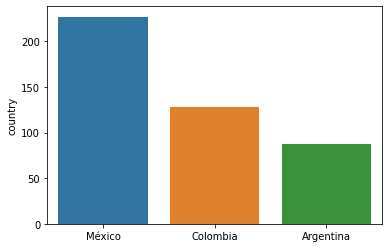

In [25]:
seaborn.barplot(x=df_norm['country'].value_counts().index, 
                y=df_norm['country'].value_counts())

Algunos otros metodos para inferir la procedencia del usuarios son:
- Identificar emojis de las banderas
- Buscar nacionalidades en el atributo *location* y el de *description*

## Inferir género

El poder asignar un género a los tweets nos permite hacer un estudio de como los diferentes géneros abordan el tema de estudio, en este caso el de Migración. Twitter no recolecta esa información al hacer la cuenta, por lo que no podemos encontrar un atributo dado por la API, pero al igual que la geolocalización, podemos inferirla a partir de atributos como el nombre, la descripción o incluso de la foto de perfil.

En esta notebook se van a revisar algunas opciones para asignar género al autor:
- Buscar nombres típicamente masculinos o femeninos en los campos de username, descripción
- Buscar pronombres (She/Her o He/His) en la descripción del usuario
- Buscar la nacionalidad (e.g.: Mexicano / Mexicana) en los campos descripción

También se podría trabajar con adjetivos, profesiones, oficios o títulos.

Nota: Dado que estos campos son abiertos y el nivel de veracidad recae completamente en cada usuario, se puede esperar que estos métodos tengan falsos positivos o negativos. Igualmente, tampoco se puede esperar que se termine asignando un género a todos los autores.

## Cargar nombres, pronombres, nacionalidades y géneros

En el directorio llamado ./resources hay un archivo llamado names_genders.csv que contiene una columna con nombres, una con el género que típicamente tienen las personas llamadas así y una última columna de si es un nombre compuesto como; Maria Jose o Jose Guadalupe.

In [2]:
df_names = pd.read_csv('./resources/names_genders.csv')

pre_text.remove_duplicated_chars(df_names, 'name')

# Names composed
df_names_double = df_names[df_names['is_double']]
regex_names_double = f"\\b((?:{'|'.join(df_names_double['name'])}))\\b"
regex_names_double = re.compile(regex_names_double)

# Single names
df_names_single = df_names[~df_names['is_double']]
regex_names_single = f"\\b((?:{'|'.join(df_names_single['name'])}))\\b"
regex_names_single = re.compile(regex_names_single)

# Names to gender
dict_names_gender = df_names.set_index('name')['gender'].to_dict()
df_names

,name,gender,is_double
0,guadalupe,F,False
1,jose,M,False
2,sofia,F,False
3,angel,M,False
4,jesus,M,False
...,...,...,...
555,aron,M,False
556,jose guadalupe,M,True
557,jose maria,M,True
558,maria guadalupe,F,True


Despues hay un diccionario con los posibles strings conteniendo pronombres y el genero que identifican. 

In [3]:
dict_pronouns_gender = {
    "she her": 'F',
    "her she": 'F',
    "he him": 'M',
    "him he": 'M'
}

regex_pronous = f"\\b((?:{'|'.join(dict_pronouns_gender.keys())}))\\b"
regex_pronous = re.compile(regex_pronous)
regex_pronous

re.compile(r'\b((?:she her|her she|he him|him he))\b', re.UNICODE)

Un diccionario con las posibles nacionalidades en las diferentes variaciones segun el genero

In [4]:
dict_nationalities_gender = {
    'mexicano': 'M',
    'mexicana': 'F',
    'colombiano': 'M',
    'colombiana': 'F',
    'argentino': 'M',
    'argentina': 'F'
}

regex_nationalities = f"\\b((?:{'|'.join(dict_nationalities_gender.keys())}))\\b"
regex_nationalities = re.compile(regex_nationalities)
regex_nationalities

re.compile(r'\b((?:mexicano|mexicana|colombiano|colombiana|argentino|argentina))\b',
re.UNICODE)

## Cargar tweets

Primero hay que cargar los tweets, específicamente el ID del tweet, el ID del usuario, el nombre del autor, su descripción. Los últimos tres campos son abiertos, es decir, que el usuario puede ingresar lo que desee a excepción de algunos caracteres especiales. Esto implica que antes de todo hay que pre-procesarlos para así reducir el número de variantes para una misma nacionalidad y/o nombre.

Nota: Usaremos de ejemplo el primer dataset que se obtuvo en la notebook "2_Definiendo_Queries.ipynb".

In [5]:
df_tweets = pd.read_json("./files/1_dataset.jsonl", lines=True)
df_tweets = df_tweets[['id', 'author_id', 'author']]

df_tweets['author_name'] = df_tweets['author'].apply(lambda x: x['name'])
df_tweets['author_description'] = df_tweets['author'].apply(lambda x: x['description'])

df_tweets = df_tweets.drop(columns=['author'])

Para evitar trabajar con autores duplicados, trabajaremos solo con una copia única de los autores, asignaremos géneros y luego haremos JOIN a los tweets usando como llave la columna `author_id`.

In [6]:
df_users = df_tweets.drop_duplicates(subset=['author_id'], 
                                  keep='last').reset_index(drop=True)
df_users = df_users.iloc[:, 1:]
df_users

,author_id,author_name,author_description
0,1361302057945333760,Activa,Somos una empresa industrial y comercial de la...
1,1391458758459600896,Jorge Araya,ver peliculas
2,1149464602452877312,Eduardo Cardoza Mata 🇸🇻🇦🇷,Embajador de El Salvador en Argentina. Salvado...
3,119160105,daniel tejeda,#Córdoba Tierra de Santos... https://t.co/eEp1...
4,805051335687081984,🇲🇽 MUCMAM-IMU MX 🏍️🛵,pero es el comportamiento del usuario quien te...
...,...,...,...
4634,377788360,Eduardo Díatri🤍💙❤️☮️💛💙,Productor y asociado para espectáculos mayores...
4635,397706715,FUVADIS INTERNACIONAL 🏳️‍🌈,"Trabajamos por la inclusión, el respeto y la i..."
4636,1176580744036196352,GaelAlejandro,¡Estoy vivooo!
4637,579360940,Juan Farre,#11


## Preprocesamiento

La siguiente función se encarga de pasar todo a minúsculas, eliminar acentos, URLs, emails, números, caracteres que no sean letras y espacios en blancos duplicados. Esto nos ayudará a que al buscar los nombres o nacionalidades en los campos, se tenga más posibilidades de encontrarlos, dado que no habrá variaciones del tipo: "NOE", "NoE", "Noe", "Noé". Permitiendo que todas esas variaciones sean validas y encontradas con la cadena de texto "noe".

In [7]:
def preprocess_for_names(df_data, new_col, flg_remove_two_chars=True):

    at_least_3_letter_reg = re.compile(r'\b\w{1,2}\b')
    at_least_3_letter_reg_capture = re.compile(r'\b(\w{2})\b')

    pre_text.initial_preprocessing(df_data, new_col,
                                   flg_remove_emojis=True,
                                   flg_lower=True)

    pre_text.remove_urls(df_data, new_col)
    pre_text.remove_emails(df_data, new_col)
    pre_text.remove_urls(df_data, new_col)
    pre_text.remove_numbers(df_data, new_col, 
                            replace_char=' ')

    pre_text.remove_duplicated_chars(df_data, new_col)
    pre_text.remove_non_alphanumeric(df_data, new_col)

    pre_text.remove_single_letters(df_data, new_col)
    
    if(flg_remove_two_chars):
        df_data[new_col] = df_data[new_col].str.replace(at_least_3_letter_reg, 
                                                        ' ', regex=True)

    pre_text.remove_multiple_blank_spaces(df_data, new_col)
    df_data[new_col] = df_data[new_col].str.strip()

    valid_texts = ((~df_data[new_col].isna()) *
                   (df_data[new_col] != '') *
                   (~df_data[new_col].str.contains(r'^\w$', regex=True)))
    df_data = df_data[valid_texts]

    return df_data

Se le aplica la función de limpieza a ambas columnas

In [8]:
df_users['author_name_og'] = df_users['author_name']
df_users = preprocess_for_names(df_users.copy(), 'author_name')
df_users = preprocess_for_names(df_users.copy(), 'author_description',
                                flg_remove_two_chars=False)
df_users[['author_name_og', 'author_name']]

,author_name_og,author_name
0,Activa,activa
1,Jorge Araya,jorge araya
2,Eduardo Cardoza Mata 🇸🇻🇦🇷,eduardo cardoza mata
3,daniel tejeda,daniel tejeda
4,🇲🇽 MUCMAM-IMU MX 🏍️🛵,mucmam imu
...,...,...
4633,Alfredo Marquez T.,alfredo marquez
4634,Eduardo Díatri🤍💙❤️☮️💛💙,eduardo diatri
4635,FUVADIS INTERNACIONAL 🏳️‍🌈,fuvadis internacional
4636,GaelAlejandro,gaelalejandro


## Buscar los nombres en la columna del nombre

In [9]:
# Copia de la tabla de usuarios
df_by_names = preprocess_for_names(df_users.copy(), 'author_name')

# Buscar nombres
df_tmp2 = df_by_names['author_name'].str.extract(regex_names_double).dropna()

df_tmp1 = df_by_names[~df_by_names.index.isin(df_tmp2.index)]['author_name']
df_tmp1 = df_tmp1.str.extract(regex_names_single).dropna()

# Asignar género en base al nombre encontrado
df_by_names['extracted_name'] = pd.concat([df_tmp1, df_tmp2])[0]
df_by_names['gender'] = df_by_names['extracted_name'].map(dict_names_gender)

df_by_names = df_by_names.dropna()
df_by_names[['author_name', 'extracted_name', 'gender']]

,author_name,extracted_name,gender
1,jorge araya,jorge,M
2,eduardo cardoza mata,eduardo,M
3,daniel tejeda,daniel,M
5,fabian neiman,fabian,M
11,rodolfo alcide,rodolfo,M
...,...,...,...
4629,agustin milan gomez,agustin,M
4630,agustin basilio,agustin,M
4632,jorge gomez monge,jorge,M
4633,alfredo marquez,alfredo,M


## Buscar los probombres en la descripción

In [10]:
# Descartar usuarios a los que ya se les asigno un género
df_pronouns = df_users[~df_users['author_id'].isin(df_by_names['author_id'])].copy()

# Buscar los probombres en la descripción
df_pronouns['extracted_pronoun'] = df_pronouns['author_description'].str.extract(regex_pronous).dropna()

# Asignar un género en base a los pronombres encontrados
df_pronouns['gender'] = df_pronouns.dropna()['extracted_pronoun'].map(dict_pronouns_gender)

df_pronouns = df_pronouns.dropna()
df_pronouns[['author_name', 'extracted_pronoun', 'gender']]

,author_name,extracted_pronoun,gender
526,celia mendoza,she her,F
752,vino barato,he him,M
1612,gabe itch,he him,M
1670,karol suarez,she her,F
1698,edecan telcel taylor version,he him,M
1768,lencha huasteca uta stan,she her,F
2206,pistolita,she her,F
2351,alain rodriguez castro,he him,M
2692,paz,she her,F
3634,raf juguito mengou,he him,M


### Nota
Los siguientes métodos necesitan un mayor preprocesamiento del realizado en esta notebook, debido a que puede haber nombres de países que se confundan con la nacionalidad (e.g. Argentina) o los usuarios sean de una organización y/o negocio, pero mencionen a alguna nacionalidad. Se debería considerar añadir un paso de preprocesamiento donde se intente identificar que cuentas no son controladas por un solo individuo y representan a un conjunto.

## Buscar nacionalidades en la descripción

In [11]:
# Descartar usuarios a los que ya se les asigno un género
df_nationalities = df_users.loc[~(df_users['author_id'].isin(df_by_names['author_id']) + 
                                  df_users['author_id'].isin(df_pronouns['author_id']))].copy()

# Buscar los probombres en la descripción
df_nationalities['extracted_nationality'] = df_nationalities['author_description'].str.extract(regex_nationalities).dropna()

# # Asignar un género en base a los pronombres encontrados
df_nationalities['gender'] = df_nationalities.dropna()['extracted_nationality'].map(dict_nationalities_gender)

df_nationalities = df_nationalities.dropna()
df_nationalities[['author_description', 'extracted_nationality', 'gender']]

,author_description,extracted_nationality,gender
49,donde el el tengan paz un vago lector sexoso i...,colombiano,M
52,argentina es inviable por los argentinos,argentina,F
90,cuenta oficial de la secretaria de la juventud...,argentina,F
96,hincha de river puxa asturias puxa bolos cuatr...,argentina,F
112,real embajada de noruega ante la republica arg...,argentina,F
...,...,...,...
4460,trabajamos para defender los derechos de las l...,argentina,F
4525,colombiano democrata amante de la naturaleza,colombiano,M
4528,astrologa poetisa viajera colombiana amo los a...,colombiana,F
4529,tucuman argentina dios patria familia lic admi...,argentina,F


## Buscar nombres en la descripción del usuario

In [12]:
# # Descartar usuarios a los que ya se les asigno un género
# df_description = df_users.loc[~(df_users['author_id'].isin(df_by_names['author_id']) + 
#                                 df_users['author_id'].isin(df_pronouns['author_id']) + 
#                                 df_users['author_id'].isin(df_nationalities['author_id']))].copy()

# # Extraer nombres de la descripción
# df_tmp2 = df_description['author_description'].str.extract(regex_names_double).dropna()

# df_tmp1 = df_description[~df_description.index.isin(df_tmp2.index)]['author_description']
# df_tmp1 = df_tmp1.str.extract(regex_names_single).dropna()

# # Asignar genero a los nombres
# df_description['extracted_name'] = pd.concat([df_tmp1, df_tmp2])[0]
# df_description['gender'] = df_description['extracted_name'].map(dict_names_gender)

# df_description = df_description.dropna()
# df_description[['author_description', 'extracted_name', 'gender']]

## Añadir la columna gender a cada tweet

Primero se juntan las tablas de los usuarios con género obtenidos con los diferentes métodos

In [14]:
df_genders = pd.concat([df_by_names, df_pronouns, df_nationalities])
df_genders = df_genders.drop(columns=['extracted_name', 'extracted_pronoun', ])

df_genders = df_genders[['author_id', 'gender']]
df_genders.columns = ['author_id', 'author_gender']
df_genders

,author_id,author_gender
1,1391458758459600896,M
2,1149464602452877312,M
3,119160105,M
5,705239258148290560,M
11,1385219885891047424,M
...,...,...
4460,1166728119434301440,F
4525,317321263,M
4528,1402075690019786752,F
4529,1146517522927280128,F


Se hace el merge de las tablas, el equivalente a un JOIN de SQL

In [15]:
df_tweets = df_tweets.merge(df_genders, on='author_id', how='left')

<AxesSubplot:ylabel='author_gender'>

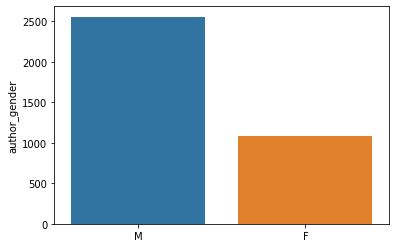

In [16]:
seaborn.barplot(x=df_tweets['author_gender'].value_counts().index, 
                y=df_tweets['author_gender'].value_counts())

In [17]:
df_tweets['author_gender'] = df_tweets['author_gender'].fillna('NaN')

In [18]:
df_tweets['author_gender'].value_counts()

NaN    5121
M      2559
F      1089
Name: author_gender, dtype: int64

## Más ideas
- Buscar profesiones y sus abstracciones en el nombre del la cuenta. E.g.: Doctor/Dr. y Doctora/Dra.
- Buscar titulos como "Papá", "Mamá", "Coordinador", "Coordinadora"
- Buscar adjetivos calificativos en la descripción
- Identificar cuentas que representen a Secretarias Publicas, Oraganización, Clubs, Empresas, etc.
- Aplicar un NER para hacer las busquedas de manera más inteligentes y focalizada